<a href="https://colab.research.google.com/github/naufalkr/opencv-image-filtering/blob/main/Segmentation_and_Morphological_Operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Naufal Khairul Rizky
### 5025221127
### Pengolahan Citra dan Visi Komputer

### Tugas 3: Segmentation and Morphological Operations


# Import Libraries


In [73]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import flood, binary_dilation
from skimage.segmentation import clear_border
from skimage.color import label2rgb
from skimage.measure import label

# Segmentation

## Filter Gradient

In [6]:
def apply_prewitt(image):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    grad_x = cv2.filter2D(image, -1, kernelx)
    grad_y = cv2.filter2D(image, -1, kernely)
    return np.sqrt(grad_x**2 + grad_y**2)

In [7]:
def apply_roberts(image):
    kernelx = np.array([[1, 0], [0, -1]])
    kernely = np.array([[0, 1], [-1, 0]])
    grad_x = cv2.filter2D(image, -1, kernelx)
    grad_y = cv2.filter2D(image, -1, kernely)
    return np.sqrt(grad_x**2 + grad_y**2)

In [8]:
def apply_sobel(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    grad_x = cv2.filter2D(image, cv2.CV_64F, kernel_x)
    grad_y = cv2.filter2D(image, cv2.CV_64F, kernel_y)

    sobel_gradient = np.sqrt(grad_x**2 + grad_y**2)
    return sobel_gradient

## Region Segmentation

In [38]:
def apply_otsu_threshold(image):
    _, otsu_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_image

In [39]:
def apply_adaptive_threshold(image):
    adaptive_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return adaptive_image

## Region Growing

In [74]:
def binview(img, mask, color='r', dilate_pixels=1):
    colors = {
        'r': np.array([1, 0, 0]),
        'g': np.array([0, 1, 0]),
        'b': np.array([0, 0, 1]),
        'y': np.array([1, 1, 0]),
        'c': np.array([0, 1, 1]),
        'm': np.array([1, 0, 1]),
        'k': np.array([0, 0, 0]),
        'w': np.array([1, 1, 1])
    }
    # Create a RGB image from grayscale image.
    img_color = np.dstack((img, img, img))

    # Ensure do not modify the original color image and the mask
    img_color = img_color.copy()

    mask_ = mask.copy()
    mask_ = binary_dilation(mask_, np.ones((dilate_pixels, dilate_pixels)))

    # Defines the pixel color used for the mask in the figure.
    cc = colors[color]

    # remove artifacts connected to image border
    cleared = clear_border(mask_)
    if np.all(cleared):
        mask_ = cleared

    # label image regions
    label_image = label(mask_)
    img_color = label2rgb(label_image, image=img_color, colors=[cc], bg_label=0)

    return img_color  # add(img_color, img_color)


In [75]:
def apply_region_growing(img, seed_point, tolerance=20):
    mask = flood(img, seed_point, tolerance=tolerance)
    mask = binary_dilation(mask, np.ones((3, 3)))

    return mask

## Hough Transformation

In [128]:
def apply_hough_transform(image):
    # Canny Edge Detection
    mag_im = cv2.Canny(image, 50, 400)

    # Hough Transform
    r_step = 1
    rmax = np.sqrt(image.shape[0] ** 2 + image.shape[1] ** 2)
    r_vec = np.arange(-rmax, rmax, r_step)
    t_step = np.pi / 180
    t_vec = np.arange(0, np.pi, t_step)
    acc_mat = np.zeros((r_vec.shape[0], t_vec.shape[0]))

    TH = 200  # Threshold for HoughLines
    lines = cv2.HoughLines(mag_im, r_step, t_step, TH)

    # Draw lines on the image
    res = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    if lines is not None:
        for r_t in lines:
            rho = r_t[0, 0]
            theta = r_t[0, 1]

            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            res = cv2.line(res, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)

    return res

## Mean Shift & Watershed

In [136]:
def apply_mean_shift(image):
    # Convert image to grayscale and apply bilateral filter for smoothing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.bilateralFilter(image, 11, 21, 7)

    # Apply mean shift
    shifted = cv2.pyrMeanShiftFiltering(blurred, sp=21, sr=51)
    return shifted

In [196]:
def apply_watershed(image):
    # Convert to grayscale and apply thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal using morphological transformations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(image, markers)
    result = image.copy()
    result[markers == -1] = [0, 255, 0]  # Boundary marked with red
    return result

# Morphology

## Morphological Operations

In [153]:
def apply_erosion(image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.erode(image, kernel, iterations=1)

In [154]:
def apply_dilation(image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.dilate(image, kernel, iterations=1)

In [155]:
def apply_opening(image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

In [156]:
def apply_closing(image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

In [157]:
def fill_holes(image):
    im_flood_fill = image.copy()
    h, w = image.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    cv2.floodFill(im_flood_fill, mask, (0, 0), 255)
    im_flood_fill_inv = cv2.bitwise_not(im_flood_fill)
    img_out = image | im_flood_fill_inv
    return img_out

# Image Loader and Display

In [14]:
def load_image_from_path(path):
    img = cv2.imread(path)
    return img

In [138]:
def apply_filter_and_display(image, filter_types):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered_images = []

    # Apply filters
    for filter_type in filter_types:
        if filter_type == 'Prewitt':
            filtered_image = apply_prewitt(gray_image)
        elif filter_type == 'Roberts':
            filtered_image = apply_roberts(gray_image)
        elif filter_type == 'Sobel':
            filtered_image = apply_sobel(gray_image)
        elif filter_type == 'Otsu Threshold':
            filtered_image = apply_otsu_threshold(gray_image)
        elif filter_type == 'Adaptive Threshold':
            filtered_image = apply_adaptive_threshold(gray_image)
        elif filter_type == 'Mean Shift':
            filtered_image = apply_mean_shift(image)
        elif filter_type == 'Watershed':
            filtered_image = apply_watershed(image)
        filtered_images.append((filter_type, filtered_image))

    # Display original and filtered images
    plt.figure(figsize=(15, 8))

    plt.subplot(1, len(filter_types) + 1, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    for idx, (filter_type, filtered_image) in enumerate(filtered_images):
        plt.subplot(1, len(filter_types) + 1, idx + 2)
        if filter_type in ['Mean Shift', 'Watershed']:
            plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(filtered_image, cmap='gray')
        plt.title(f"{filter_type} Filter")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [158]:
def apply_morpho_filter_and_display(image, filter_types, kernel_size=(5, 5)):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    filtered_images = []

    # Apply filters
    for filter_type in filter_types:
        if filter_type == 'Erosion':
            filtered_image = apply_erosion(gray_image, kernel_size)
        elif filter_type == 'Dilation':
            filtered_image = apply_dilation(gray_image, kernel_size)
        elif filter_type == 'Opening':
            filtered_image = apply_opening(gray_image, kernel_size)
        elif filter_type == 'Closing':
            filtered_image = apply_closing(gray_image, kernel_size)
        elif filter_type == 'Fill Holes':
            filtered_image = fill_holes(gray_image)
        filtered_images.append((filter_type, filtered_image))

    # Display original and filtered images
    plt.figure(figsize=(15, 8))

    plt.subplot(1, len(filter_types) + 1, 1)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    for idx, (filter_type, filtered_image) in enumerate(filtered_images):
        plt.subplot(1, len(filter_types) + 1, idx + 2)
        plt.imshow(filtered_image, cmap='gray')
        plt.title(f"{filter_type} Filter")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [90]:
def display_region_growing(img, mask, seg, si, sj):
    fig, ax = plt.subplots(1, 3, figsize=(14, 8))

    ax[0].imshow(img, cmap='gray')
    ax[0].plot(sj, si, 'r+')
    ax[0].axis('off')
    ax[0].set_title('Original Image with Seed')

    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Region Growing Mask')

    ax[2].imshow(seg)
    ax[2].axis('off')
    ax[2].set_title('Segmented Image')

    plt.tight_layout()
    plt.show()

In [133]:
def display_hough(image):
    figsize=(10, 10)
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Hough Transform
    result_image = apply_hough_transform(gray_image)

    # Display original and result image
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_image)
    plt.title("Hough Transform Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Testing


## Filter Gradient Test


In [33]:
path = '/content/x-ray-image-inlinedetect-18.png'
image = load_image_from_path(path)

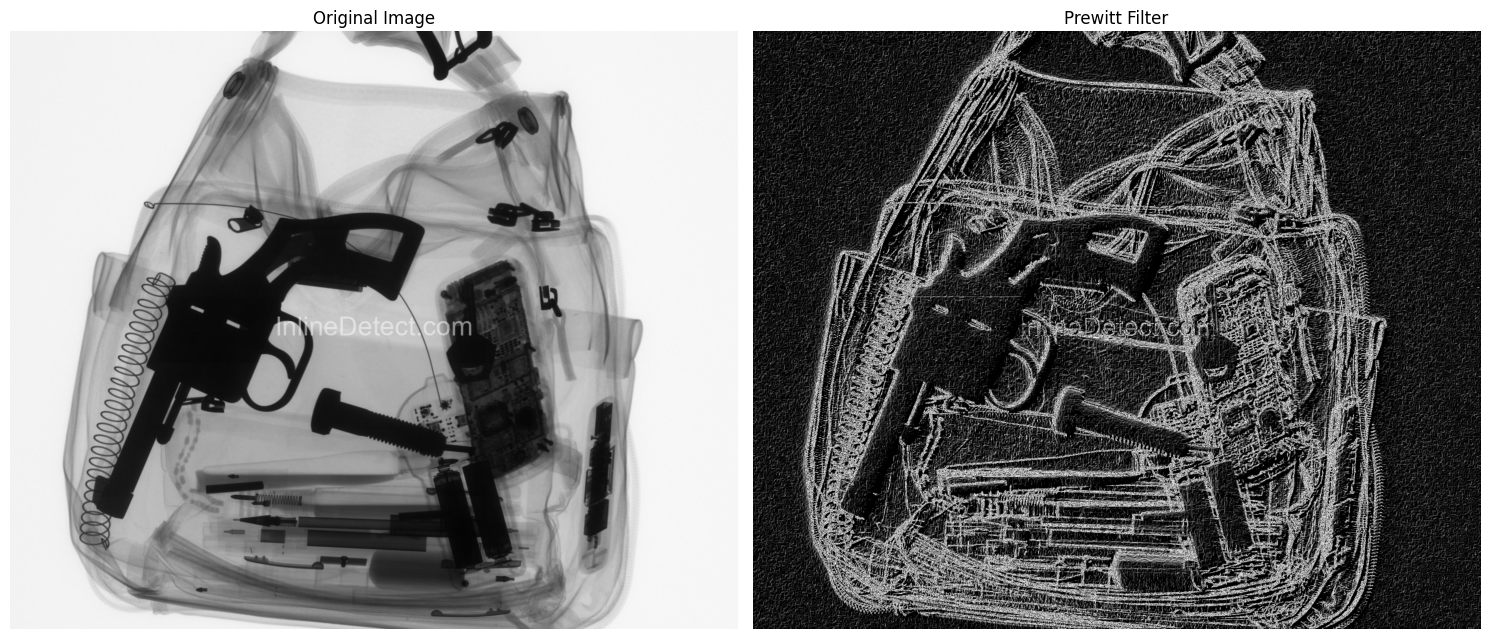

In [34]:
filter_type = ['Prewitt']
apply_filter_and_display(image, filter_type)

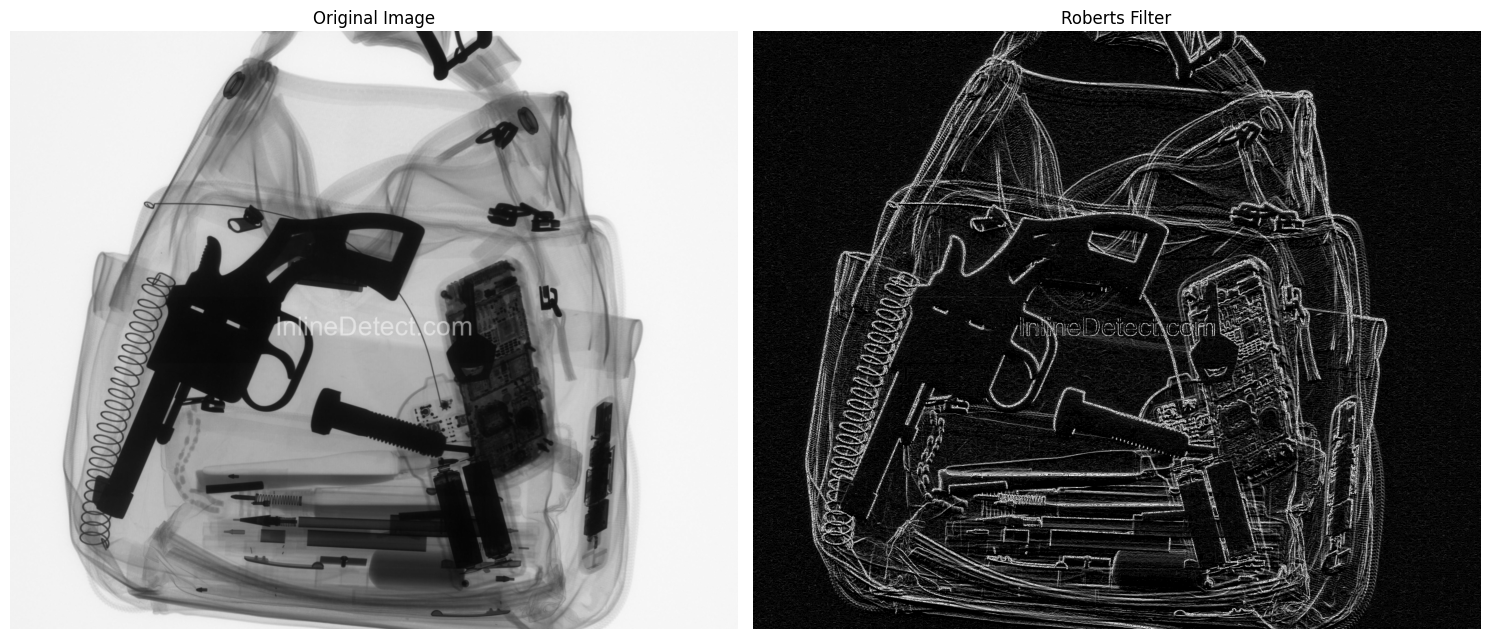

In [35]:
filter_type = ['Roberts']
apply_filter_and_display(image, filter_type)

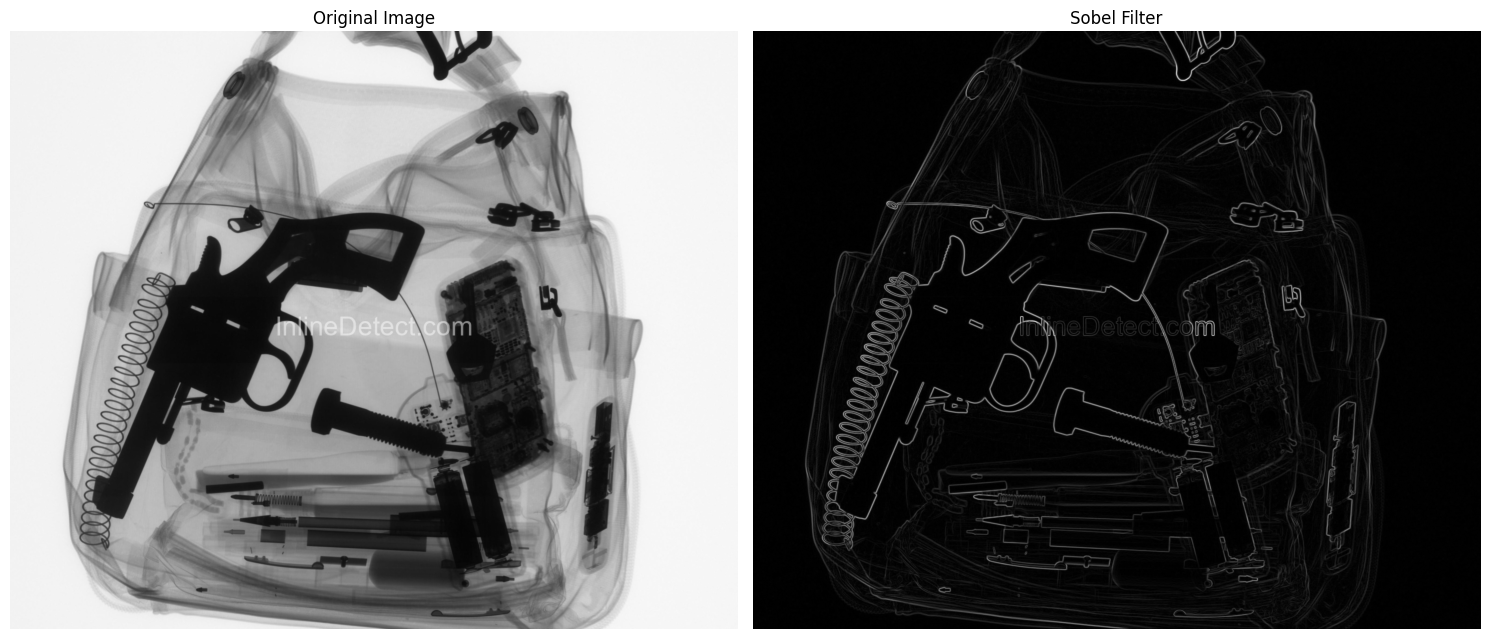

In [36]:
filter_type = ['Sobel']
apply_filter_and_display(image, filter_type)

## Region Segmentation Test

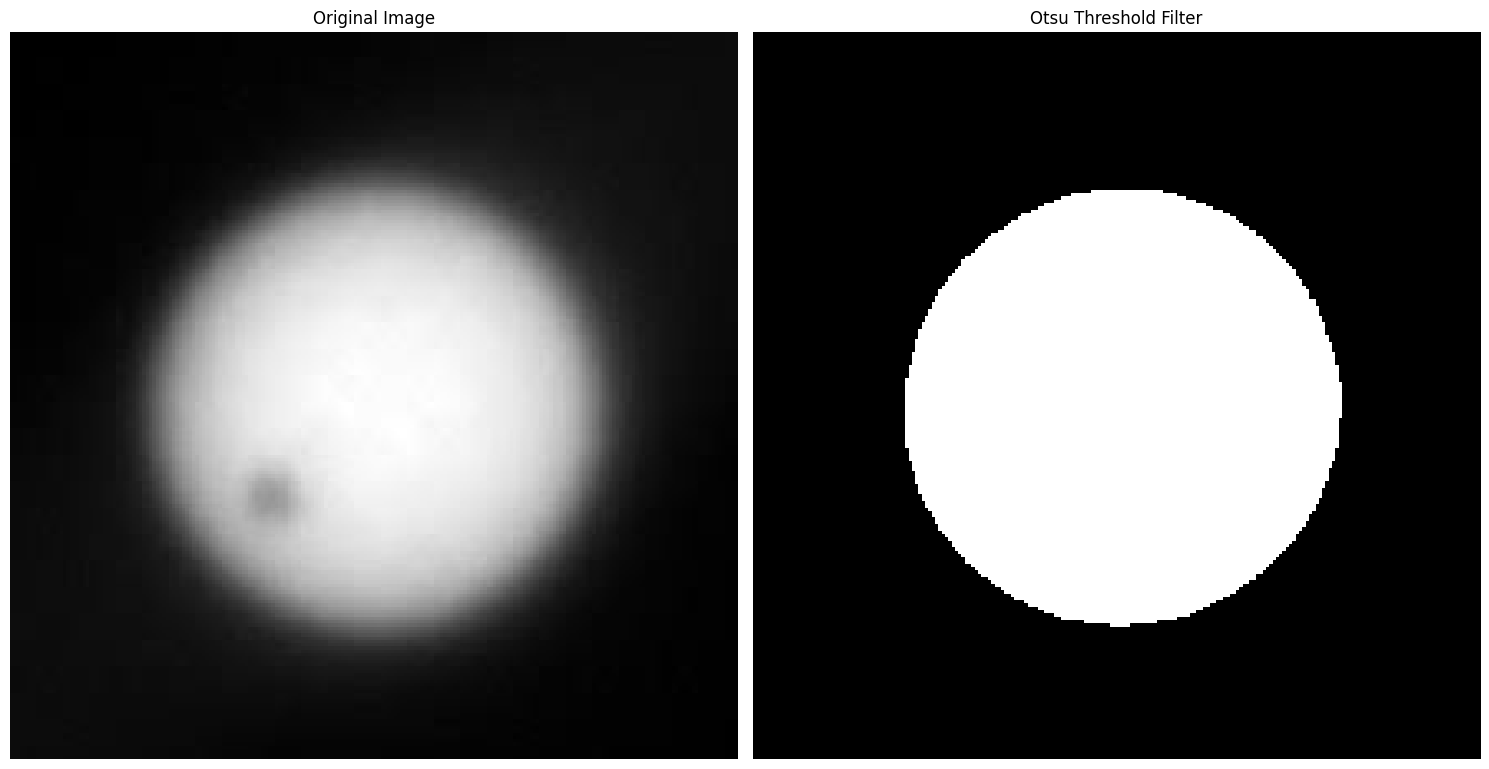

In [67]:
# Otsu Threshold
path = '/content/images (2).jpeg'
image = load_image_from_path(path)
threshold_types = ['Otsu Threshold']
apply_filter_and_display(image, threshold_types)

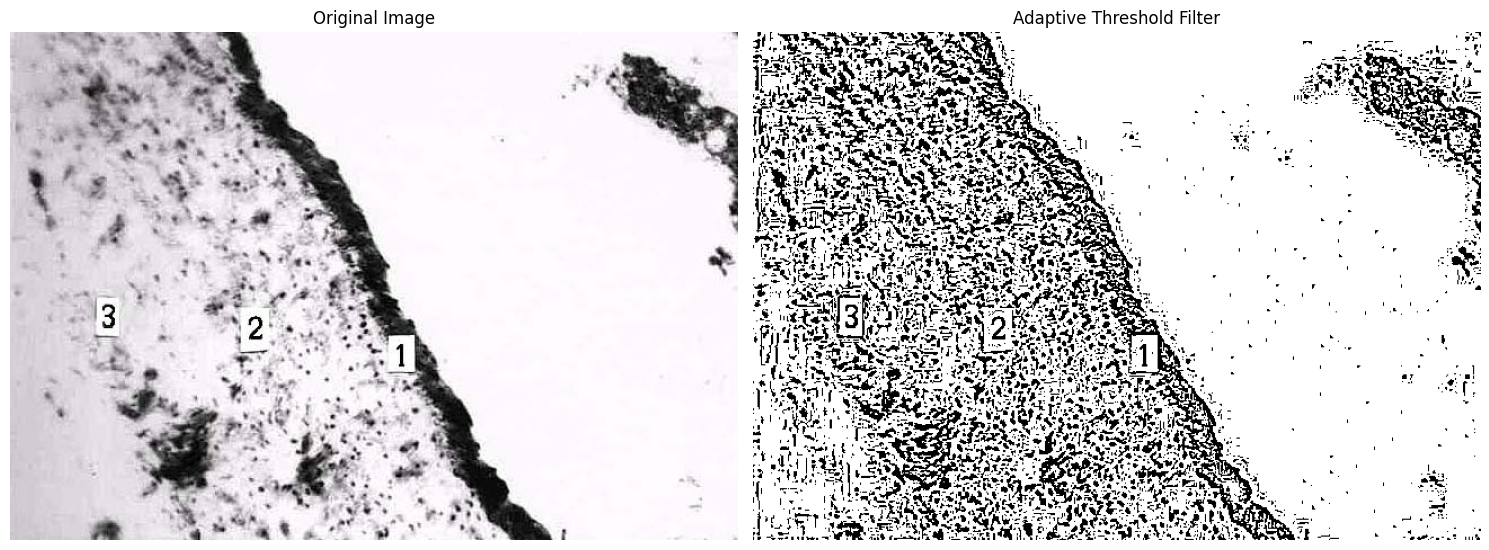

In [71]:
# Adaptive Threshold
path = '/content/fig4.gif'
image = load_image_from_path(path)
threshold_types = ['Adaptive Threshold']
apply_filter_and_display(image, threshold_types)

## Region Growing Test

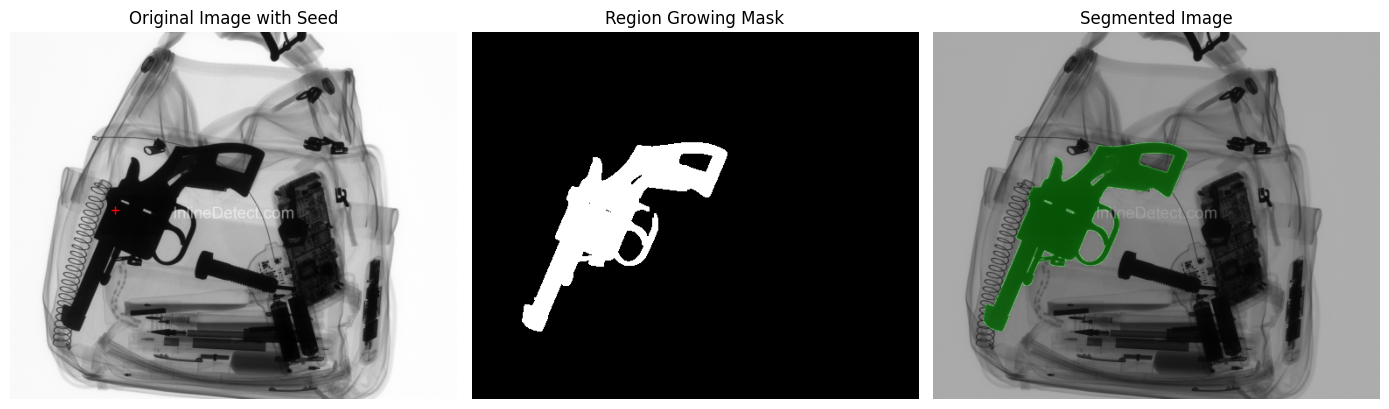

In [111]:
img = cv2.imread('/content/x-ray-image-inlinedetect-18.png', 0)  # grayscale
img = cv2.resize(img, None, fx=0.35, fy=0.35, interpolation=cv2.INTER_AREA)

th = 40  # threshold
si, sj = (203, 120)  # Seed
# si, sj = (276, 70)  # Seed

mask = apply_region_growing(img, (si, sj), tolerance=th)

seg = binview(img, mask, 'g')

display_region_growing(img, mask, seg, si, sj)

## Hough Transformation Test

In [ ]:
# !wget https://www.dropbox.com/s/4dwmepxgi4nhd7g/building.png

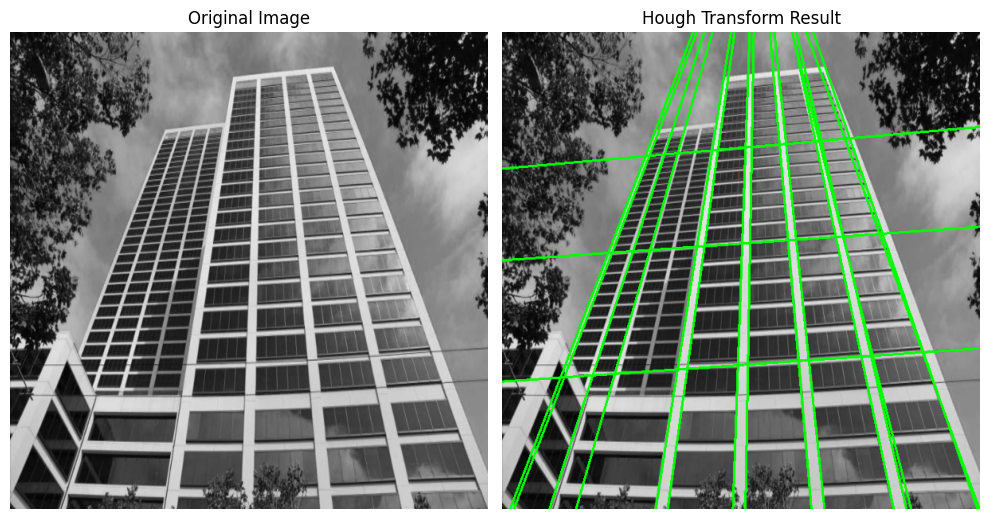

In [135]:
# Load and process image
image = cv2.imread("building.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (600, 600))

display_hough(image)

## Mean Shift Test

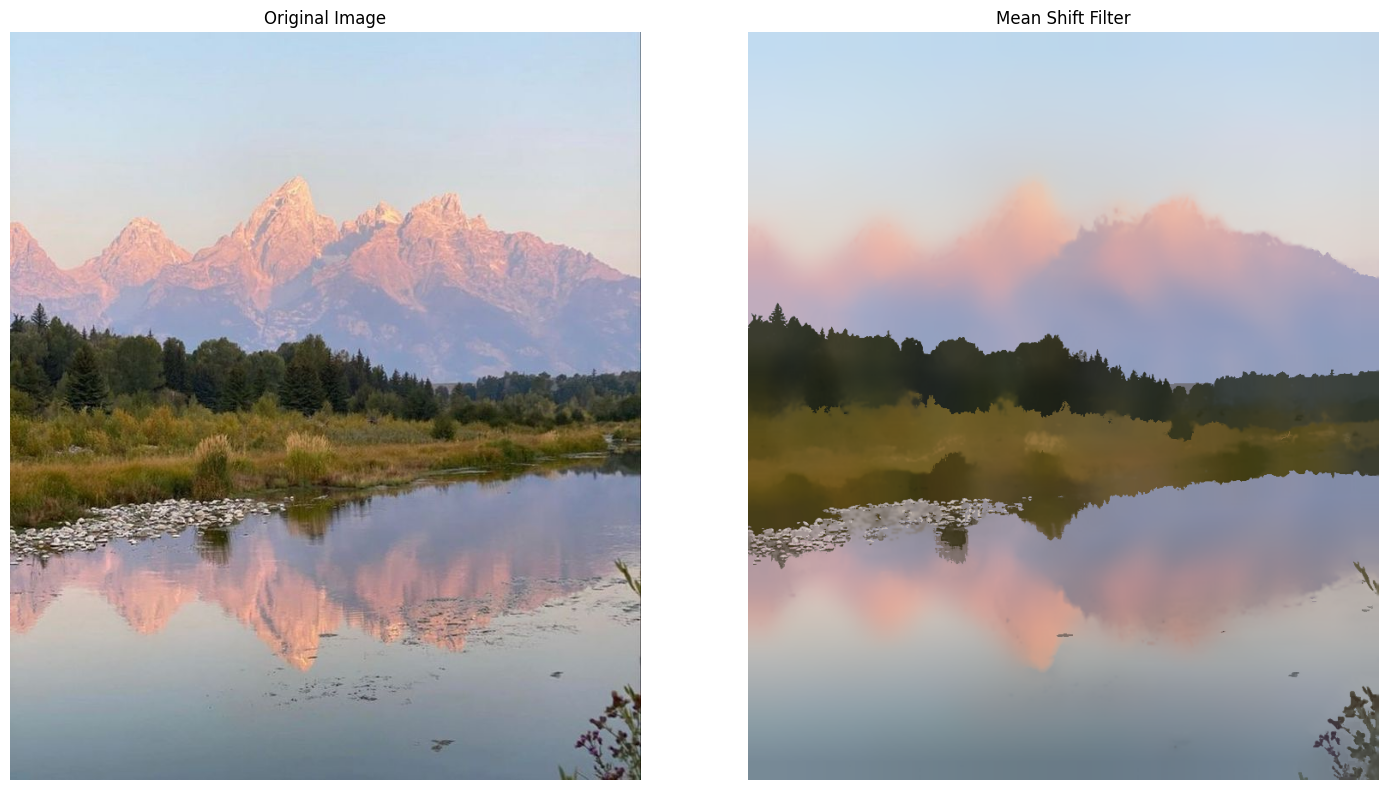

In [143]:
image = cv2.imread("/content/23acdb1af78cbb04c56049c5158ff728.jpg")
filter_types = ['Mean Shift']
apply_filter_and_display(image, filter_types)

## Watershed Test

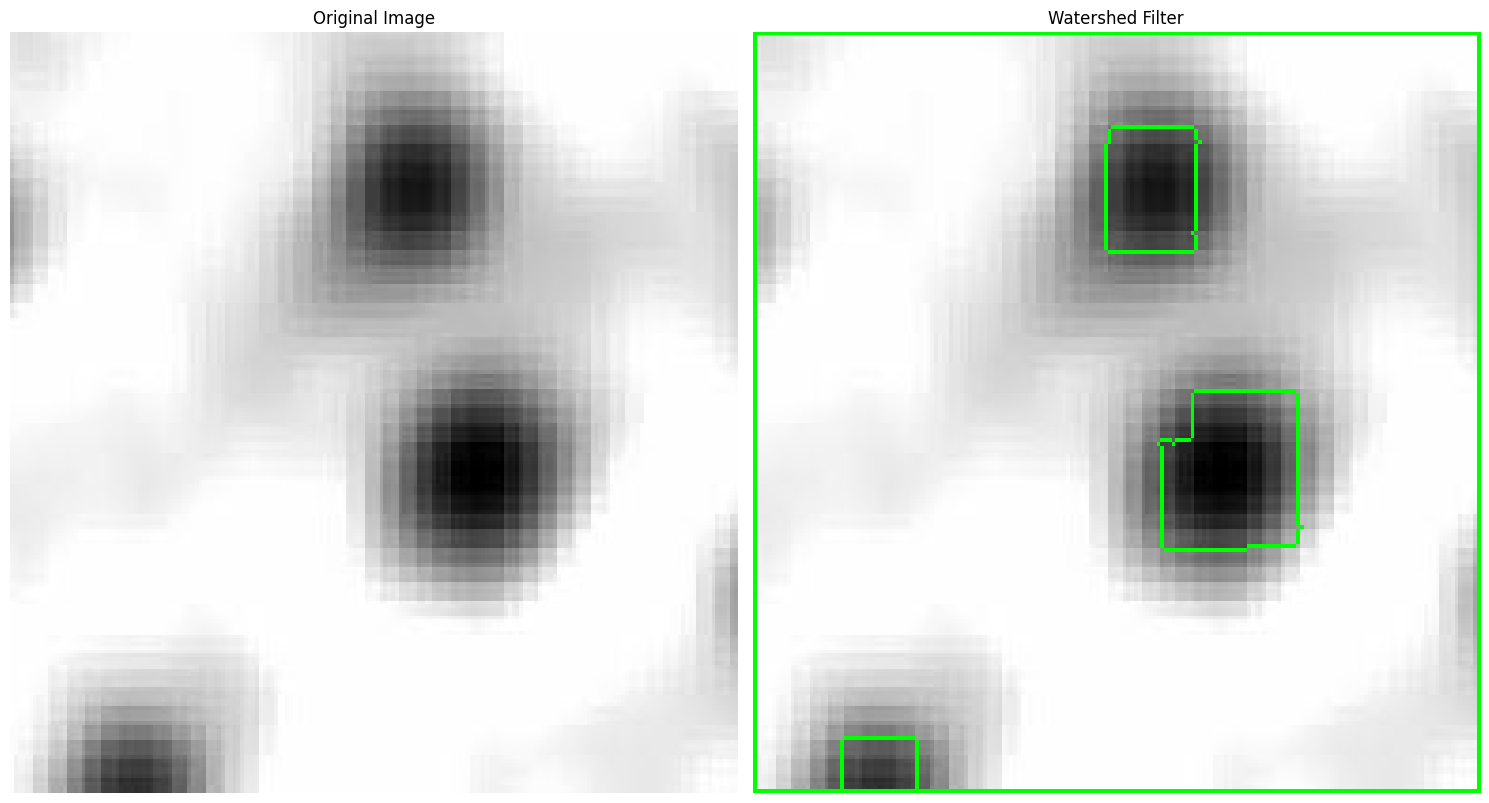

In [197]:
image = cv2.imread("/content/images (8).jpeg")
filter_types = ['Watershed']
apply_filter_and_display(image, filter_types)

## Morphological Operations Test

In [191]:
# !wget https://www.dropbox.com/s/fok3q35hm1o2k13/jota.png
# !wget https://www.dropbox.com/s/ccebfv6fhlk6h4q/tazmania.png
img1 = cv2.imread('tazmania.png', 0)  # Load as grayscale
img2 = cv2.imread('jota.png', 0)  # Load as grayscale

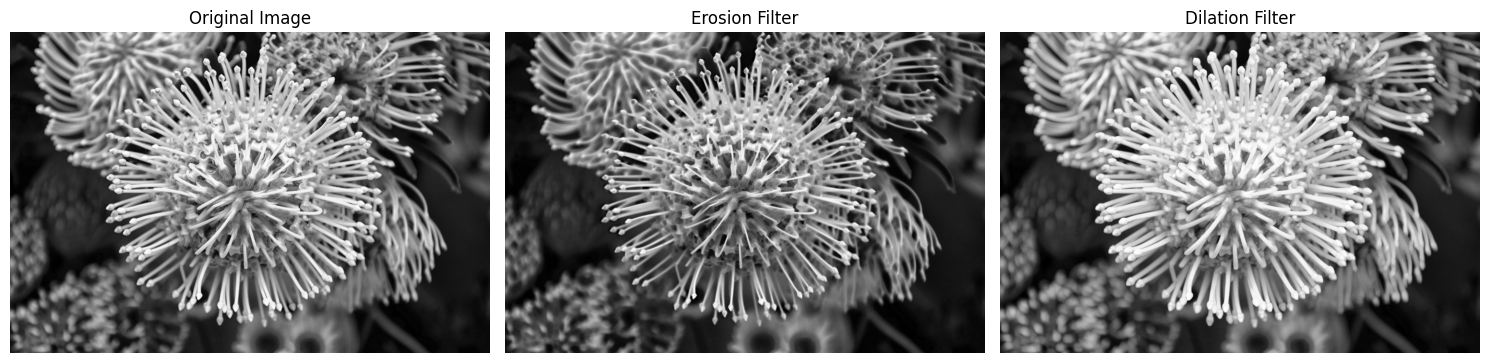

In [192]:
# Erosion & Dilation
apply_morpho_filter_and_display(img1, ['Erosion', 'Dilation'])

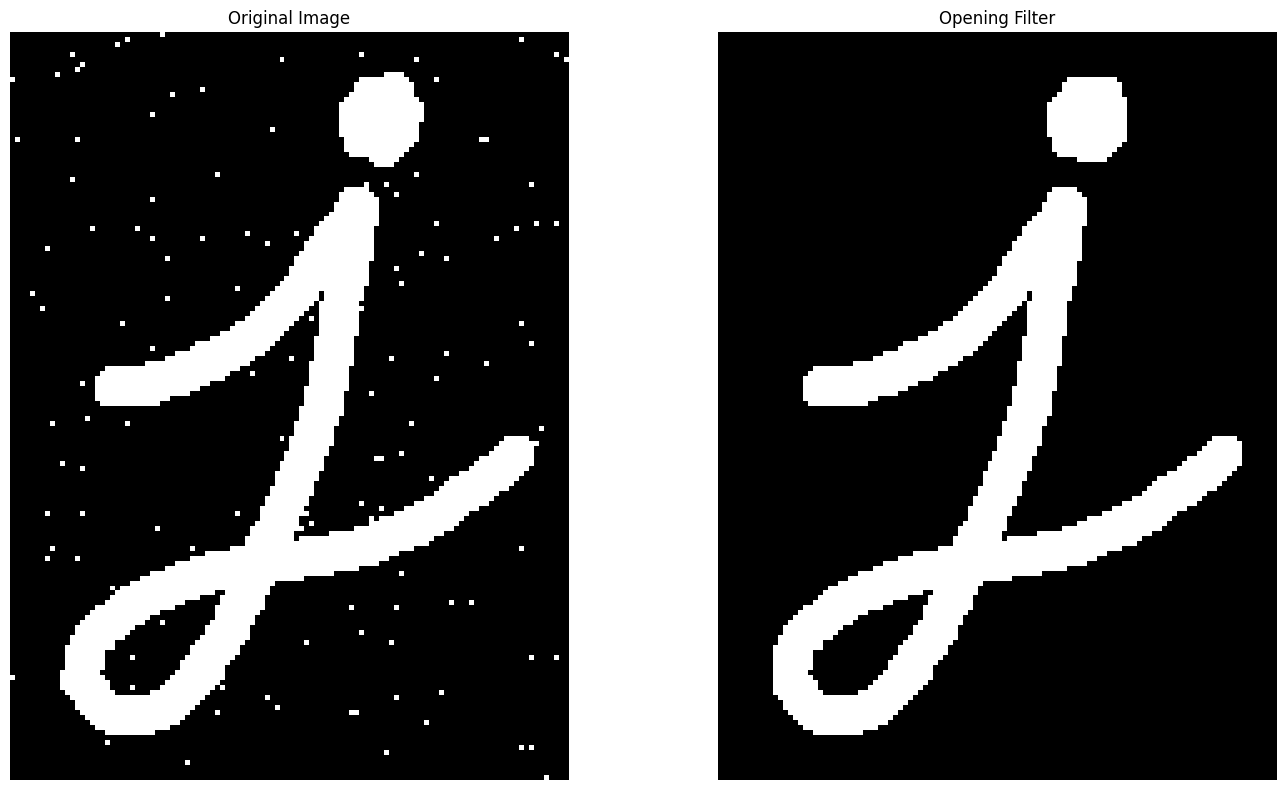

In [193]:
# Opening
(N,M) = img2.shape

img_noise = img2.copy()

for i in range(N):
  for j in range(M):
    if np.random.rand()>0.99:
      img_noise[i,j] = 255

apply_morpho_filter_and_display(img_noise, ['Opening'])

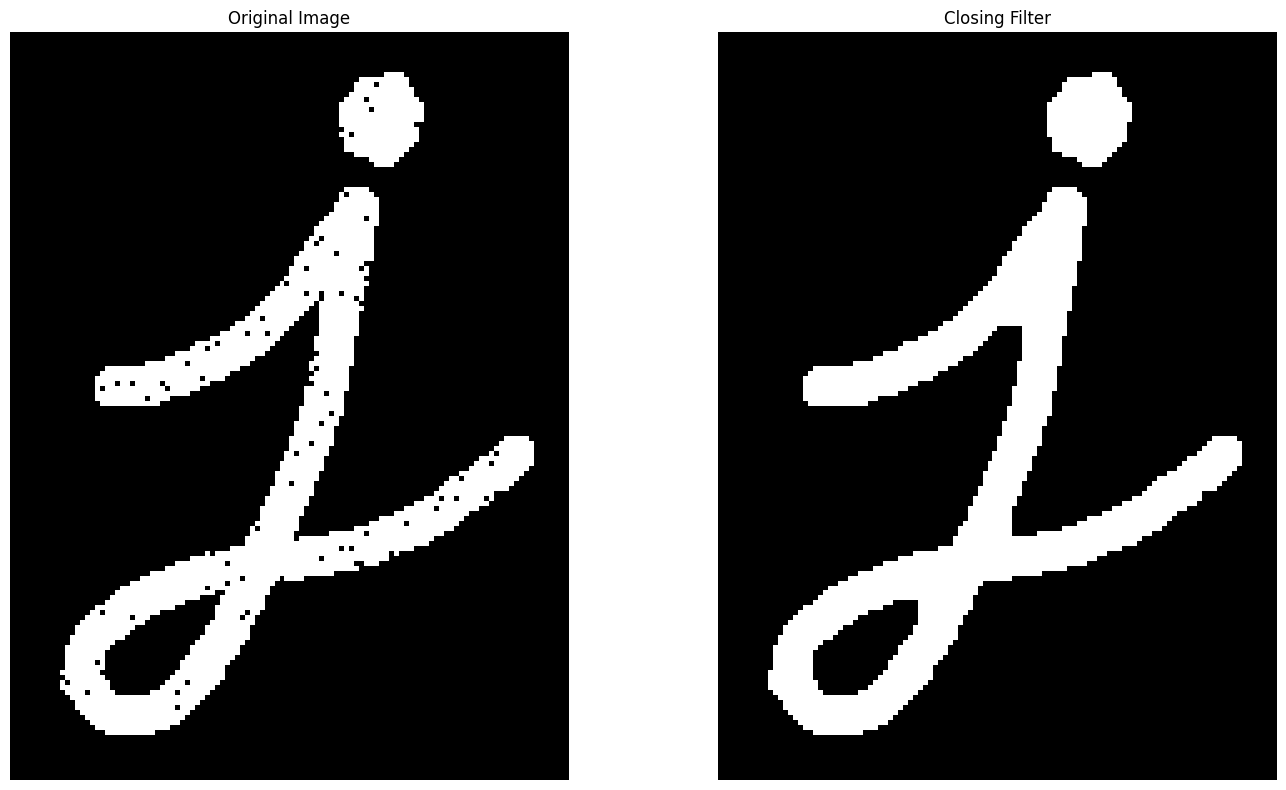

In [194]:
# Closing
(N,M) = img2.shape

img_noise = img2.copy()

for i in range(N):
  for j in range(M):
    if np.random.rand()>0.97:
      img_noise[i,j] = 0

apply_morpho_filter_and_display(img_noise, ['Closing'])

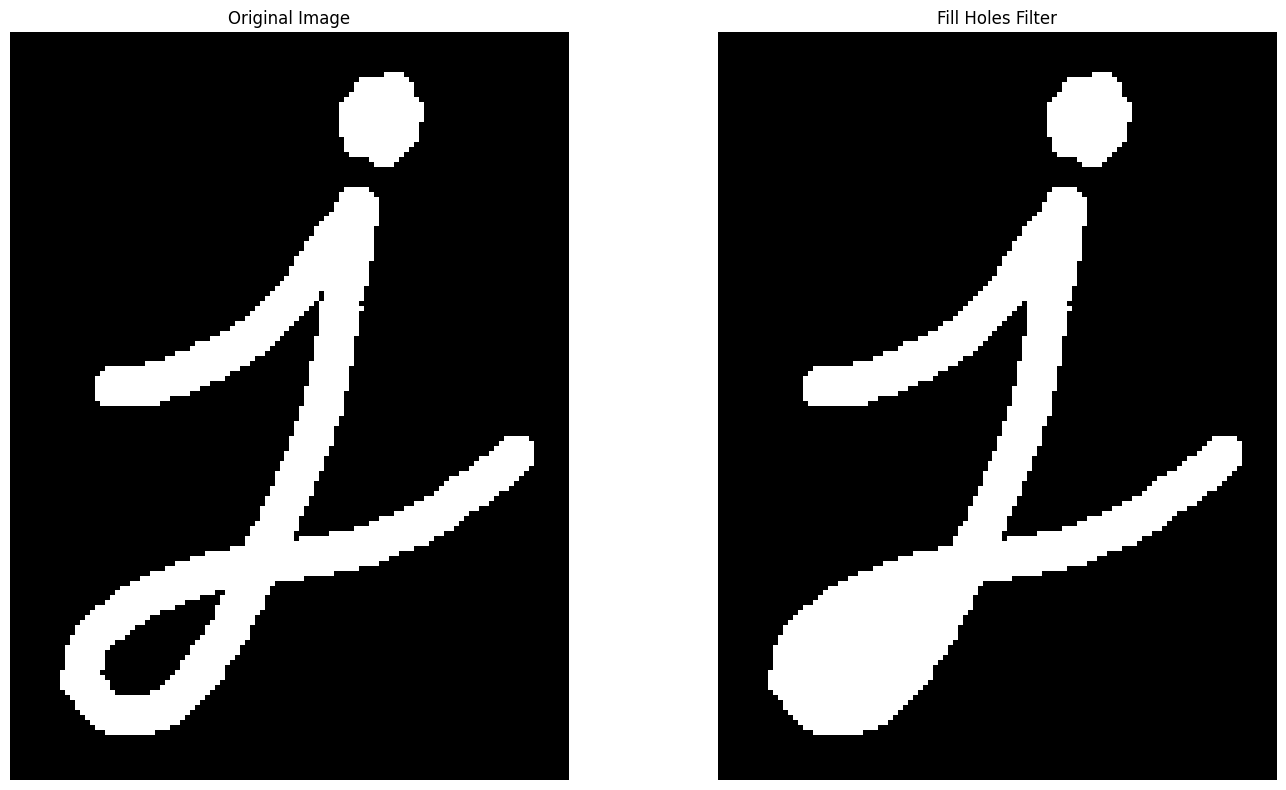

In [195]:
# Hole Filling
apply_morpho_filter_and_display(img2, ['Fill Holes'])